# AT&T Spam Detector #

In [3]:
!pip install spacy -q

In [ ]:
!pip install --upgrade transformers safetensors tensorflow

In [74]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io

from pathlib import Path

import numpy as np

**Download data**

In [75]:
data_input_file_url  = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv'
p = tf.keras.utils.get_file(origin=data_input_file_url, cache_dir=".")
print(p)
data_input_local_file_path = os.path.join("/",'content', str(Path(p).relative_to('./')))
print(data_input_local_file_path)

./datasets/spam.csv
/content/datasets/spam.csv


**Load csv as Pandas dataFrame, display dataset summary**

In [76]:
spam_pd_dataset = pd.read_csv(filepath_or_buffer=data_input_local_file_path, delimiter="," ,encoding='ISO-8859-1')
spam_pd_dataset.head()
spam_pd_dataset.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
spam_pd_dataset.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**DataSet shape**

In [77]:
print(f"number of rows :", spam_pd_dataset.shape[0])
print()

print(f"number of columns :", spam_pd_dataset.shape[1])
print()

number of rows : 5572

number of columns : 5



**See columns null proportion**

In [78]:
serie = spam_pd_dataset.isnull().sum() * 100/spam_pd_dataset.shape[0]
na_cols_dtf = serie.reset_index( ).rename(columns={"index":"column", 0:"na_prop"}).sort_values(by='na_prop',ascending=False)
na_cols_dtf

,column,na_prop
4,Unnamed: 4,99.892319
3,Unnamed: 3,99.784637
2,Unnamed: 2,99.102656
0,label,0.000000
1,text,0.000000


**Duplicates ?**

In [79]:

print(f"number of duplicates : {spam_pd_dataset.duplicated().sum()}")

number of duplicates : 403


**Drop duplicates**

In [80]:
spam_pd_dataset.drop_duplicates(subset='text', keep='first',inplace=True)
spam_pd_dataset = spam_pd_dataset.reset_index(drop=True)
spam_pd_dataset.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Utility functions

In [81]:
from typing import List
import random

def get_ramdom_indices(texts : List, labels:List,n_sample:int) -> List:
  assert len(texts) == len(labels)
  assert n_sample <= len(texts)
  return random.sample(range(len(texts)), k=n_sample)


def print_indexes(texts : List, labels:List, indexes:List):
  print(f'dataset sample, size : {len(indexes)}')
  print('-----------------------------------')
  for text, label in zip([texts[i] for i in indexes], [labels[i] for i in indexes]):
    print(f"label : {label}", " ---- ", f"text : {text}")
  return indexes

def print_samples(texts : List, labels:List,n_sample:int) -> List:
  random_indices = get_ramdom_indices(texts=texts, labels=labels, n_sample=n_sample)
  print_indexes(texts=texts, labels=labels, indexes=random_indices)
  return random_indices

def get_random_indexes(dtf: pd.DataFrame,n_sample:int) -> List:
  assert n_sample <= dtf.shape[0]
  return np.random.choice(dtf.index, size=n_sample, replace=False)

def get_random_sample(dtf: pd.DataFrame,n_sample:int) -> pd.DataFrame:
  idx_lst = get_random_indexes(dtf=dtf,n_sample=n_sample)
  return dtf.iloc[idx_lst]

def get_sample(dtf: pd.DataFrame,idx_lst:np.ndarray) -> pd.DataFrame:
  return dtf.iloc[idx_lst]



### Drop na columns, encode labels


In [82]:
spam_pd_dataset['label'].unique()


array(['ham', 'spam'], dtype=object)

In [83]:
spam_label_encode_mapping = {'ham':0, 'spam':1}

In [84]:
def drop_na_columns(spam_dtf:pd.DataFrame):
  columns_to_delete = list(filter(lambda c: c.startswith('Unnamed:'),spam_dtf.columns.tolist()))
  spam_dtf.drop(columns=columns_to_delete, inplace=True)

def encode_labels(spam_dtf:pd.DataFrame):
  spam_dtf['label'] = spam_dtf['label'].map(spam_label_encode_mapping)

def extract_texts_labels(spam_dtf:pd.DataFrame) -> tuple:
  texts, labels = [], []
  texts, labels = spam_dtf['text'].tolist(), spam_dtf['label'].tolist()
  return texts, labels

def extract_cleantexts_labels(spam_dtf:pd.DataFrame) -> tuple:
  texts, labels = [], []
  texts, labels = spam_dtf['text_clean'].tolist(), spam_dtf['label'].tolist()
  return texts, labels


In [85]:
drop_na_columns(spam_dtf=spam_pd_dataset)
encode_labels(spam_dtf=spam_pd_dataset)
spam_pd_dataset.head(5)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Make a copy of raw texts and labels (0,1) for later use**

In [86]:
raw_text_list, raw_binary_label_list = extract_texts_labels(spam_dtf=spam_pd_dataset)

**Computing ham / spam proportions in the full dataset**

In [87]:
HAM_PROPORTION = raw_binary_label_list.count(0)/len(raw_binary_label_list)
SPAM_PROPORTION = raw_binary_label_list.count(1)/len(raw_binary_label_list)
print(f"HAM_PROPORTION : {HAM_PROPORTION}")
print(f"SPAM_PROPORTION : {SPAM_PROPORTION}")

HAM_PROPORTION : 0.873669955503966
SPAM_PROPORTION : 0.12633004449603405


## **Texts preprocessing so it can be consumed by neural network.**

1. Nlp processing : clean text, remove punctuations, tokenize, lemmatize, discard STOP_WORDS with
spacy fr_core_news_sm

2. Tokens encoding / vectorization**

In [15]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [88]:
import en_core_web_sm
nlp = en_core_web_sm.load()

### 1. Clean texts, remove punctuations, Lemmatize and discard stop_words with spacy


In [89]:
import re
from spacy.lang.en.stop_words import STOP_WORDS

def clean_lemmatize_texts(spam_dtf:pd.DataFrame):
  spam_dtf['text_clean'] = spam_dtf['text'].map(lambda s: re.sub(r'[^\w\s]', '', s).replace(" +"," ").lower().strip())
  spam_dtf['text_clean'] = spam_dtf['text_clean'].map(lambda s: " ".join([token.lemma_ for token in nlp(s) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
  spam_dtf['length'] = spam_dtf['text_clean'].map(lambda s: len(s.split()))
  return spam_dtf


In [90]:
clean_lemmatize_texts(spam_dtf=spam_pd_dataset)
spam_pd_dataset.head(5)

,label,text,text_clean,length
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,14
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,22
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,6
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,4


### Extract texts and labels as lists to feed TensorFlow DataSets

In [91]:
texts_cleaned, labels = extract_cleantexts_labels(spam_dtf=spam_pd_dataset)

## Visualize most frequent words for Ham / Spam with WordCloud

In [20]:

!pip install wordcloud -q

In [92]:

ham_texts = list(filter(lambda x: x[1] == 0, zip(texts_cleaned,labels)))
spam_texts = list(filter(lambda x: x[1] == 1, zip(texts_cleaned,labels)))
print(len(texts_cleaned))
print(f'ham count : {len(ham_texts)}')
print(f'spam count : {len(spam_texts)}')

# flatten list of words
ham_text_corpus = " ".join([text for text, label in ham_texts])
spam_text_corpus = " ".join([text for text, label in spam_texts])

5169
ham count : 4516
spam count : 653


In [22]:
assert((len(labels)==len(texts_cleaned)))

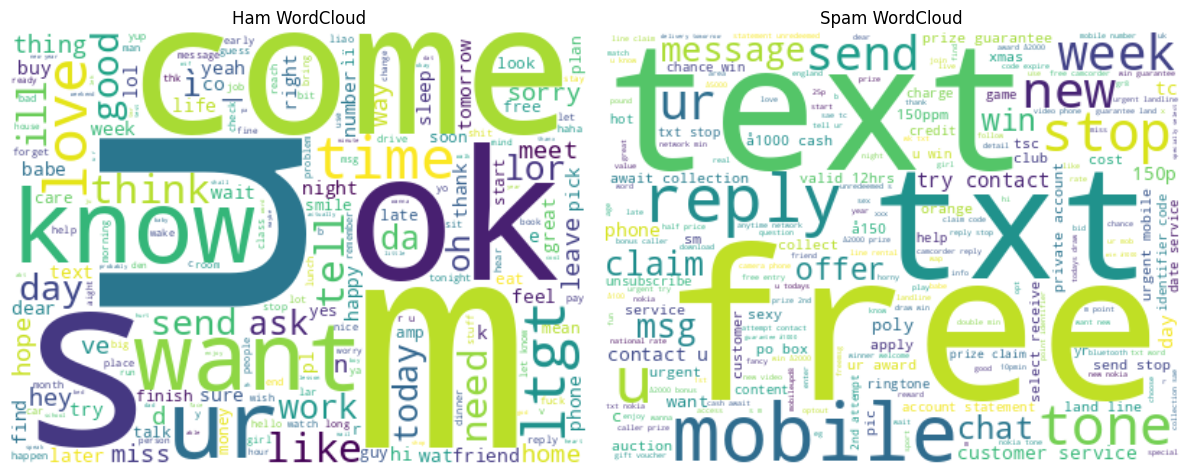

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_ham = WordCloud(width=400, height=300, background_color='white',stopwords=STOP_WORDS).generate(ham_text_corpus)
wordcloud_spam = WordCloud(width=400, height=300, background_color='white',stopwords=STOP_WORDS).generate(spam_text_corpus)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left pane
axes[0].imshow(wordcloud_ham, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Ham WordCloud")

# Right pane
axes[1].imshow(wordcloud_spam, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Spam WordCloud")

plt.tight_layout()
plt.show()

### 2. Tokens encoding / vectorization

In [93]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_cleaned)
encoded_text_sequences = tokenizer.texts_to_sequences(texts_cleaned)
# pad sequences to max sequence length
encoded_text_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_text_sequences, padding="post")
num_records = len(encoded_text_sequences)
max_seqlen = len(encoded_text_sequences[0])
print("{:d} sentences, max length: {:d}".format(num_records, max_seqlen))
print('text_sequences.shape : ', encoded_text_sequences.shape)

5169 sentences, max length: 72
text_sequences.shape :  (5169, 72)


### Create token to index dict and index to token dict

In [94]:

word2idx_dict = tokenizer.word_index
idx2word_dict = {v:k for k, v in word2idx_dict.items()}
word2idx_dict["PAD"] = 0
idx2word_dict[0] = "PAD"
vocab_size = len(word2idx_dict)
print("vocab size: {:d}".format(vocab_size))

vocab size: 8179


### Convert labels to categorical

In [95]:
NUM_CLASSES = 2
cat_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)
encoded_text_sequences = np.array(encoded_text_sequences)

### The first versions of CNN model was giving an accuracy of 1 on both train set and test set wich is suprising / suspect. ###

### Even after duplicate suppression on the primary datasets, encoding with tokenizer generates duplicates (same sequence of encoding for a doc). So I first remove duplicates in the encoded_text_sequences ###

In [96]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42
BATCH_SIZE = 64

# Remove duplicates
unique_pairs = {}
unique_sequences_X  = []
unique_sequences_y = []
print(f"Before removing duplicates : {len(encoded_text_sequences)}")
for x, y in zip(encoded_text_sequences, cat_labels):
    key = tuple(x)
    if key not in unique_pairs:
        unique_pairs[key] = True
        unique_sequences_X .append(x)
        unique_sequences_y.append(y)

unique_sequences_X = np.array(unique_sequences_X)
unique_sequences_y = np.array(unique_sequences_y)
print(f"After removing duplicates: {len(unique_sequences_X)}")

# Shuffle
np.random.seed(SEED)
indices = np.arange(len(unique_sequences_X))
np.random.shuffle(indices)

X_shuffled = unique_sequences_X[indices]
y_shuffled = unique_sequences_y[indices]


Before removing duplicates : 5169
After removing duplicates: 5085


### Create TensorFlow Dataset

In [97]:
tensor_dataset = tf.data.Dataset.from_tensor_slices((X_shuffled, y_shuffled))

num_records = len(X_shuffled)
train_size = int(TRAIN_RATIO * num_records)
val_size = int(VAL_RATIO * num_records)
test_size = num_records - train_size - val_size

train_tensor_dataset = tensor_dataset.take(train_size)
val_tensor_dataset = tensor_dataset.skip(train_size).take(val_size)
test_tensor_dataset = tensor_dataset.skip(train_size + val_size)

### Group tensor flow DataSets into batches ###

In [98]:
train_tensor_dataset = train_tensor_dataset.batch(BATCH_SIZE)
val_tensor_dataset = val_tensor_dataset.batch(BATCH_SIZE)
test_tensor_dataset = test_tensor_dataset.batch(BATCH_SIZE)

### Define shared Optimizer, loss function and metric to compile models

In [99]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_function = tf.keras.losses.CategoricalCrossentropy()
categ_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

# **Define a baseline Model (CNN based)**

Machine Learning litterature states that Conv1D achieve good results for spam detection
Embedding -> Conv1D -> MaxPool1D -> Dropout -> Flatten -> Dense

In [100]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [101]:

class SpamDetector_cnn_model(tf.keras.Model):
      def __init__(self, vocab_size, embed_size, sentence_max_length,
            conv_nb_filters, conv_kernel_size, output_size, maxpool1d_poolsize,
                   dropout_rate,
            **kwargs):
        super(SpamDetector_cnn_model, self).__init__(**kwargs)
        #As of recent versions of TensorFlow (2.11+), input_length is no longer required for most use cases.
        # TensorFlow can automatically infer the input length from the actual input during the first forward pass.
        #self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=sentence_max_length)
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_size)
        self.conv1D = Conv1D(filters=conv_nb_filters, kernel_size=conv_kernel_size, activation="relu")
        self.maxpooling = MaxPool1D(pool_size=maxpool1d_poolsize)
        self.dropout = Dropout(dropout_rate)
        self.flatten = Flatten()
        self.dense = Dense(units=output_size, activation="softmax")

      def call(self, inputs):
        x = self.embedding(inputs)
        x = self.conv1D(x)
        x = self.maxpooling(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [102]:
CONV_NB_FILTERS = 256
CONV_KERNEL_SIZE = 3
VOCAB_SIZE = vocab_size #8179
EMBEDDING_DIM = 64
MAX_SEQLEN = max_seqlen #72
NUM_CLASSES = 2

MAXPOOL1D_POOLSIZE = 2
DROPOUT_RATE = 0.5

model_cnn = SpamDetector_cnn_model(
    VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQLEN,
    CONV_NB_FILTERS, CONV_KERNEL_SIZE, NUM_CLASSES,MAXPOOL1D_POOLSIZE,DROPOUT_RATE)

#model_cnn.build(input_shape=(None, max_seqlen))

dummy_input = tf.keras.Input(shape=(MAX_SEQLEN,), dtype=tf.int32)
model_cnn(dummy_input)

model_cnn.summary()

Model: "spam_detector_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 72, 64)         │       523,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 70, 256)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        17,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,786 (2.25 MB)

 Trainable params: 590,786 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

**Following code is just for displaying input/output shapes of each layer (SpamDetector_model expressed with functional api)**

In [33]:
inputs = tf.keras.Input(shape=(MAX_SEQLEN,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = tf.keras.layers.Conv1D(CONV_NB_FILTERS, CONV_KERNEL_SIZE, activation="relu")(x)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

_model = tf.keras.Model(inputs, outputs)
_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 72, 64)         │       523,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 70, 256)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        17,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,786 (2.25 MB)

 Trainable params: 590,786 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model using**

- categorical_crossentropy for loss function

- accuracy for metrics

In [103]:
model_cnn.compile(optimizer=adam_optimizer, loss=loss_function,
    metrics=[categ_accuracy_metric])

Compute classes distribution / weights for fit method

In [104]:
y_train_list = []
for _, y_batch in train_tensor_dataset:
    y_train_list.append(y_batch.numpy())

y_train_array = np.vstack(y_train_list)
y_train_labels = np.argmax(y_train_array, axis=1) # convertir one-hot → entiers

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Classes weights :", class_weight_dict)
NUM_EPOCHS = 20


Classes weights : {0: np.float64(0.5687120485778204), 1: np.float64(4.138372093023256)}


# Train model and keep history

In [ ]:
model_1_cnn_training_history = model_cnn.fit(train_tensor_dataset, epochs=NUM_EPOCHS,
    validation_data=val_tensor_dataset,
    class_weight=class_weight_dict)

# Surpinsingly, model's accuracy increases quickly and gets closer to 100% on train set after a few epochs.

Looking at learning process / loss & accuracy over epochs

In [106]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_1_cnn_training_history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model_1_cnn_training_history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.update_layout(title='Training and Validation Loss')
fig.show()

In [107]:
model_1_cnn_training_history.history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

In [108]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_1_cnn_training_history.history["categorical_accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=model_1_cnn_training_history.history["val_categorical_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.update_layout(title='Training and Validation accuracy')
fig.show()

# Evaluate model on new data

In [109]:
class_names = spam_label_encode_mapping.keys()
print(type(class_names))
print(list(class_names))

<class 'dict_keys'>
['ham', 'spam']


In [116]:
def compute_confusion_matrix(model, tensor_test_dataset):
  y_test_labels, y_test_predictions = [], []

  for X_batch, Y_batch in tensor_test_dataset:
      # X_batch : input_ids + attention_mask
      Y_pred = model.predict_on_batch(X_batch)

      # Convertir one-hot encoded into class indice
      y_true = np.argmax(Y_batch.numpy(), axis=1)
      y_pred = np.argmax(Y_pred, axis=1)

      y_test_labels.extend(y_true.tolist())
      y_test_predictions.extend(y_pred.tolist())

  print("test accuracy: {:.3f}".format(accuracy_score(y_test_labels, y_test_predictions, normalize=True)))
  print("test recall (TP/TP+FN): {:.3f}".format(recall_score(y_test_labels, y_test_predictions)))
  print("test f1-score: {:.3f}".format(f1_score(y_test_labels, y_test_predictions)))
  return confusion_matrix(y_test_labels, y_test_predictions)

def display_confusion_matrix(conf_matrix, class_names):
  plt.figure(figsize=(6, 5))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names)

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.show()

In [117]:
cm = compute_confusion_matrix(model_cnn,test_tensor_dataset)
print("confusion matrix")
print(cm)

test accuracy: 0.975
test recall (TP/TP+FN): 0.875
test f1-score: 0.905
confusion matrix
[[654   6]
 [ 13  91]]


### **RESULTS** ###

- test accuracy: 0.975
- **test f1-score: 0.905**
- **confusion matrix [[654   6] [ 13  91]]**

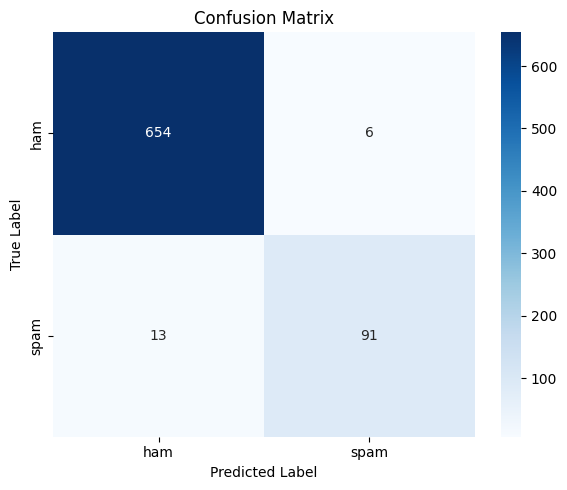

In [118]:
class_names = list(spam_label_encode_mapping.keys())
display_confusion_matrix(cm, class_names)

# Transfer learning (BERT)

In [45]:
!pip install -q transformers datasets
#!pip install --upgrade transformers safetensors tensorflow

## Tokenize / encode raw texts with BertTokenizer (no need to pre-process / lemmatize upstream)

In [119]:

print("Eager execution enabled:", tf.executing_eagerly())

Eager execution enabled: True


In [120]:
assert(len(raw_text_list)==len(raw_binary_label_list))

### Explore how bert tokenizer output looks like ###

In [121]:

from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_encoded_text_sequences = bert_tokenizer(
    raw_text_list,
    padding="max_length",
    truncation=True,
    max_length=MAX_SEQLEN,
    return_tensors="np"   # numpy arrays pour compatibilité
)

print(type(bert_encoded_text_sequences))
#print(f'tokenizer.max_len_single_sentence : {tokenizer.max_len_single_sentence}')
#<class 'transformers.tokenization_utils_base.BatchEncoding'> subclass of dictionary
input_ids, attention_mask = bert_encoded_text_sequences['input_ids'], bert_encoded_text_sequences['attention_mask']
print(f'type(input_ids) : {type(input_ids)}')
print(f'input_ids.shape : {input_ids.shape}' )
print(input_ids[:1])
print(f'type(attention_mask : {type(attention_mask)}')
print(f'attention_mask.shape : {attention_mask.shape}')
print(f'attention_mask sample : {attention_mask[:1]}')

<class 'transformers.tokenization_utils_base.BatchEncoding'>
type(input_ids) : <class 'numpy.ndarray'>
input_ids.shape : (5169, 72)
[[  101  2175  2127 18414 17583  2391  1010  4689  1012  1012  2800  2069
   1999 11829  2483  1050  2307  2088  2474  1041 28305  1012  1012  1012
  25022  2638  2045  2288 26297 28194  1012  1012  1012   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]
type(attention_mask : <class 'numpy.ndarray'>
attention_mask.shape : (5169, 72)
attention_mask sample : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Inspect bert model architecture to find embedding layer ###

In [ ]:
# Load BERT
from transformers import TFBertModel

bert = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)
def inspect_trainable_layers(bert_model):
    """
    bert_model: your TFBertModel or SpamDetector_BertTrsfrt_model.bert
    """
    for submodule in bert_model.submodules:
        print(f"\n=== {submodule.name} ===")
        for v in submodule.variables:
            print(f"{v.name} | shape={v.shape} | trainable={v.trainable}")

inspect_trainable_layers(bert)

### Define model Bert-model based

### We define the whole pipeline into a single cell to avoid the following issue
NotImplementedError: numpy() is only available when eager execution is enabled.

In [51]:
import tensorflow as tf, gc, os
tf.keras.backend.clear_session()
gc.collect()

0

In [122]:


MAX_SEQLEN = 128
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42
BATCH_SIZE = 64
NUM_CLASSES = 2


# Tensor dataset creation pipeline
def build_datasets(raw_text_list, labels):
    """Tokenize, one-hot encode, split and return TF datasets + class weights."""
    # Tokenize with HuggingFace → numpy arrays
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    encoded = tokenizer(
        raw_text_list,
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQLEN,
        return_tensors="np"
    )

    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]
    cat_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

    # TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {"input_ids": input_ids, "attention_mask": attention_mask},
        cat_labels
    ))

    dataset = dataset.shuffle(buffer_size=len(cat_labels), seed=SEED, reshuffle_each_iteration=False)

    # Train/val/test split
    num_records = len(cat_labels)
    train_size = int(TRAIN_RATIO * num_records)
    val_size = int(VAL_RATIO * num_records)

    train_dataset = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = dataset.skip(train_size + val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    train_ids = []
    for batch in train_dataset:
        train_ids.append(batch[0]['input_ids'].numpy())
    train_ids = np.concatenate(train_ids, axis=0)

    val_ids = []
    for batch in val_dataset:
        val_ids.append(batch[0]['input_ids'].numpy())
    val_ids = np.concatenate(val_ids, axis=0)

    print("Intersection train/val:", np.intersect1d(train_ids, val_ids))

    # Compute class weights

    y_train_list = []
    for _, y_batch in train_dataset.unbatch():
        y_train_list.append(y_batch)

    y_train_array = tf.stack(y_train_list).numpy()

    if y_train_array.ndim > 1 and y_train_array.shape[1] > 1:
        # One-hot → class indices
        y_train_labels = np.argmax(y_train_array, axis=1)
    else:
        # Already integers
        y_train_labels = y_train_array

    weights = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    class_weight_dict = dict(enumerate(weights))

    return train_dataset, val_dataset, test_dataset, class_weight_dict


# Define a BERT-based model (Transfer Learning). Freeze BERT-model parameters. Add classification head dowstream BERT model

class SpamDetectorBERT(tf.keras.Model):
    def __init__(self, num_classes=2, dropout_rate=0., pretrained="bert-base-uncased",unfreeze_embeddings=False):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(pretrained, from_pt=True)
        self.bert.trainable = False
        if unfreeze_embeddings:
            self.bert.bert.embeddings.trainable = True
        self.dropout = Dropout(dropout_rate)
        self.classifier = Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        outputs = self.bert(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output, training=training)
        return self.classifier(x)


def build_model(num_classes=2, lr=2e-5,unfreeze_embeddings=False):
    model = SpamDetectorBERT(num_classes=num_classes,unfreeze_embeddings=unfreeze_embeddings)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# training pipeline

def run_pipeline(raw_text_list, raw_binary_label_list, epochs=5, use_class_weights=True):
    # Clear previous state
    tf.keras.backend.clear_session()

    # Build datasets
    train_ds, val_ds, test_ds, cw_dict = build_datasets(raw_text_list, raw_binary_label_list)

    # Build model
    model = build_model(num_classes=NUM_CLASSES)

    history = None
    # Train
    if use_class_weights:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            class_weight=cw_dict
        )
    else:
      history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    # model evaluation on test set
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    return model, history,test_ds

def run_pipeline_unfreeze_embeddings(raw_text_list, raw_binary_label_list, epochs=5,use_class_weights=False):
    # Clear previous state
    tf.keras.backend.clear_session()

    # Build datasets
    train_ds, val_ds, test_ds, cw_dict = build_datasets(raw_text_list, raw_binary_label_list)

    # Build model
    model = build_model(num_classes=NUM_CLASSES, unfreeze_embeddings=True)

    history = None
    # Train
    if use_class_weights:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            class_weight=cw_dict
        )
    else:
      history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    return model, history, test_ds


### Train a SpamDetectorBERT with freezing bert layers ###

In [ ]:
bert_model, bert_model_history, test_ds = run_pipeline(
    raw_text_list=raw_text_list,
    raw_binary_label_list=labels,
    epochs=50
)

### As we can see accuracy : The birt-based model performs worse than the first Embedding-CNN based model in terms of accuracy.”

We can fine tune parameters such as dropout rate, learning_rate

We can remove class_weights

As we can see, in the ouputs we can see duplicates in the encoded sequences

### Compute confusion matrix

In [124]:
cm = compute_confusion_matrix(bert_model,test_ds)
print("confusion matrix")
print(cm)

test accuracy: 0.905
test recall (TP/TP+FN): 0.890
test f1-score: 0.706
confusion matrix
[[613  63]
 [ 11  89]]


### **RESULTS** ###

- test accuracy: 0.905
- **test f1-score: 0.706**
- **confusion matrix [[595   81] [ 10  90]]**

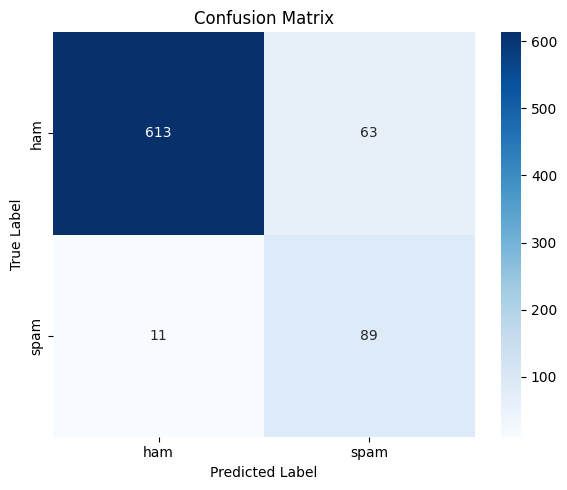

In [125]:
class_names = list(spam_label_encode_mapping.keys())
display_confusion_matrix(cm, class_names)

In [115]:
bert_model_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [126]:

fig = go.Figure()
fig.add_trace(go.Scatter(y=bert_model_history.history["accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=bert_model_history.history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.update_layout(title='Training and Validation accuracy')
fig.show()

### Train a SpamDetectorBERT with freezing bert layers and WITHOUT class_weights ###

In [ ]:
bert_model, bert_model_history, test_ds = run_pipeline(
    raw_text_list=raw_text_list,
    raw_binary_label_list=labels,
    epochs=50, use_class_weights=False
)

### Compute confusion matrix

In [128]:
cm = compute_confusion_matrix(bert_model,test_ds)
print("confusion matrix")
print(cm)

test accuracy: 0.879
test recall (TP/TP+FN): 0.060
test f1-score: 0.113
confusion matrix
[[676   0]
 [ 94   6]]


### **RESULTS** ###

- test accuracy: 0.876
- **test f1-score: 0.113**
- **confusion matrix [[675   1] [ 95  5]]**

**f1-score is bad**

**True spams are badly detected**

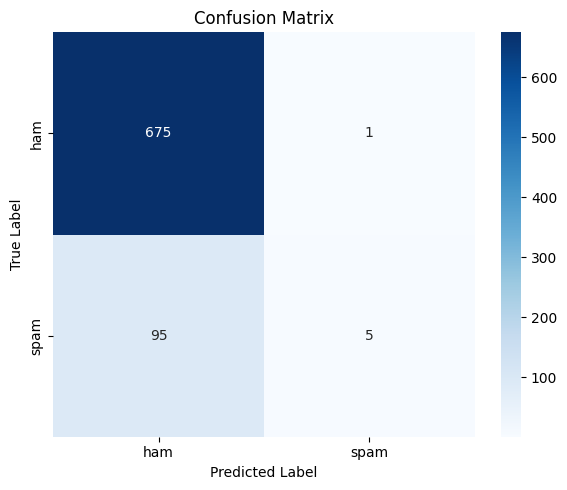

In [64]:
class_names = list(spam_label_encode_mapping.keys())
display_confusion_matrix(cm, class_names)

In [65]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=bert_model_history.history["accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=bert_model_history.history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.update_layout(title='Training and Validation accuracy')
fig.show()

### Train a SpamDetectorBERT with trainable embedding layer ###

In [ ]:
bert_model, bert_model_history,test_ds = run_pipeline_unfreeze_embeddings(
    raw_text_list=raw_text_list,
    raw_binary_label_list=labels,
    epochs=50
)



### Compute confusion matrix

In [130]:
cm = compute_confusion_matrix(bert_model,test_ds)
print("confusion matrix")
print(cm)

test accuracy: 0.874
test recall (TP/TP+FN): 0.040
test f1-score: 0.075
confusion matrix
[[674   2]
 [ 96   4]]


### **RESULTS** ###

test accuracy: 0.874

**test f1-score: 0.075**

**confusion matrix [[674   2] [ 96  4]]**

**f1-score is bad**

**True spams are badly detected**

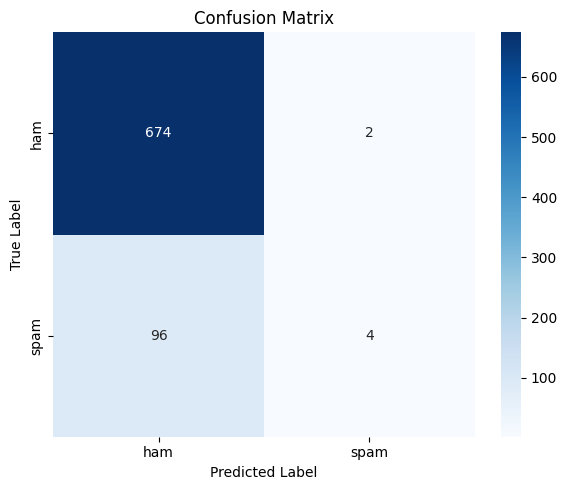

In [131]:
class_names = list(spam_label_encode_mapping.keys())
display_confusion_matrix(cm, class_names)

Looking at learning process / loss & accuracy over epochs

In [65]:
bert_model_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [132]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=bert_model_history.history["accuracy"],
                    mode='lines',
                    name='accuracy'))
fig.add_trace(go.Scatter(y=bert_model_history.history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy'))
fig.update_layout(title='Training and Validation accuracy')
fig.show()

## Summary ##

**Since dataset is not balanced (reggarding spam/ham proportion) accuracy hides
spam detection quality.**


### SpamDetector_cnn_model
- architecture
  - (Embedding & CNN based)
  - class_weights

- results
  - **f1-score : 0.905**
  - categorical_accuracy: 1.0000
  - val_categorical_accuracy: 0.9843
  - test accuracy: 0.975
  - confusion matrix: [[654   6] [ 13  91]]



-> **simple architecture**

-> **no overfitting**

-> **f1-score very good**




### SpamDetectorBERT 1
- architecture (BERT transfert learning)
  - inner bert model non trainable
  - class_weights

- results
  - **f1-score : 0.706**
  - categorical_accuracy: 0.8897
  - val_categorical_accuracy: 0.8994
  - test accuracy: 0.905
  - confusion matrix: [[613  63] [ 11  89]]


-> **BERT model trained on a very large vocabulary**

-> **less adapted to this specific vocabulary**

-> **no overfitting**

-> **f1-score correct**


### SpamDetectorBERT 2
- architecture (BERT transfert learning)
  - inner bert model non trainable
  - no class_weights

- results
  - **f1-score : 0.113**
  - categorical_accuracy: 0.8736
  - val_categorical_accuracy: 0.8774
  - test accuracy: 0.879
  - confusion matrix: [[676   0] [ 94   6]]


-> **BERT model trained on a very large vocabulary**

-> **not adapted to this specific vocabulary**

-> **model predicts almost always main class (ham)**

-> **very bad f1-score**

-> **good precision on main class**

-> **but bad ability to detect spams (6/100)**



### SpamDetectorBERT 3
- architecture (BERT transfert learning)
  - inner bert model : embedding head trainable
  - class_weights

- results
  - **f1-score : 0.075**
  - categorical_accuracy: 0.8648
  - val_categorical_accuracy: 0.8697
  - test accuracy: 0.874
  - confusion matrix: [[674   2] [ 96   4]]


-> **model predicts almost always main class (ham)**

-> **bad ability to detect spams (8/100)**

-> **very bad f1-score**
